In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression  # For comparison
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2  # chi2 for classification

In [92]:
# 1. Load the dataset
df = pd.read_csv("/content/sample_data/forestfires.csv")


In [93]:
# (a) Data Cleaning
# Handle missing values (if any) - Example:
# df.dropna(inplace=True)  # Or imputation if needed
# ... other cleaning steps

# (b) Summary Statistics
print(df.describe())

                X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192    4.559477   
min      1.000000    2.000000   18.700000    1.100000    7.900000    0.000000   
25%      3.000000    4.000000   90.200000   68.600000  437.700000    6.500000   
50%      4.000000    4.000000   91.600000  108.300000  664.200000    8.400000   
75%      7.000000    5.000000   92.900000  142.400000  713.900000   10.800000   
max      9.000000    9.000000   96.200000  291.300000  860.600000   56.100000   

             temp          RH        wind        rain         area  
count  517.000000  517.000000  517.000000  517.000000   517.000000  
mean    18.889168   44.288201    4.017602    0.021663    12.847292  
std      5.806625   16.317469    1.791653    0.295959    63.655

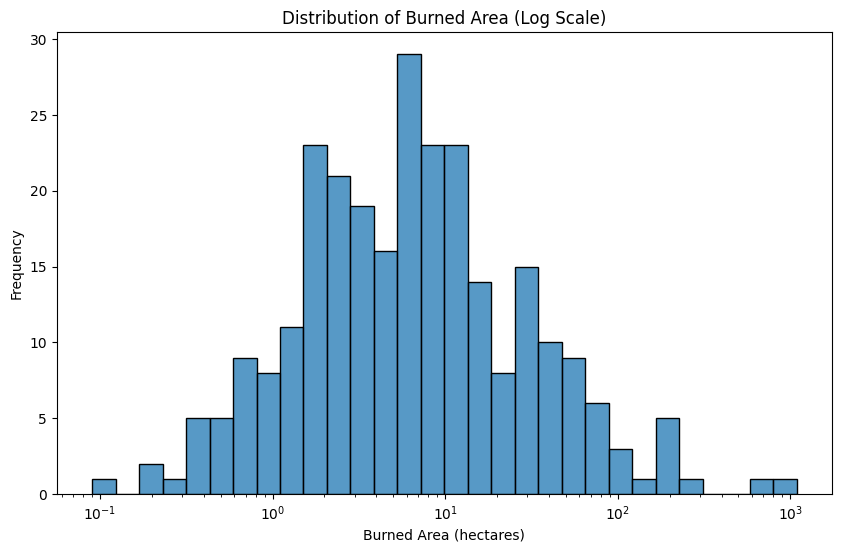

In [94]:
# (c) Visualizations
# Example: Histogram for the target variable 'area' with logarithmic scale
plt.figure(figsize=(10, 6))  # Adjust figure size for better visibility
sns.histplot(df['area'], bins=30, log_scale=True)  # Use log scale on x-axis
plt.title('Distribution of Burned Area (Log Scale)')
plt.xlabel('Burned Area (hectares)')
plt.ylabel('Frequency')
plt.show()

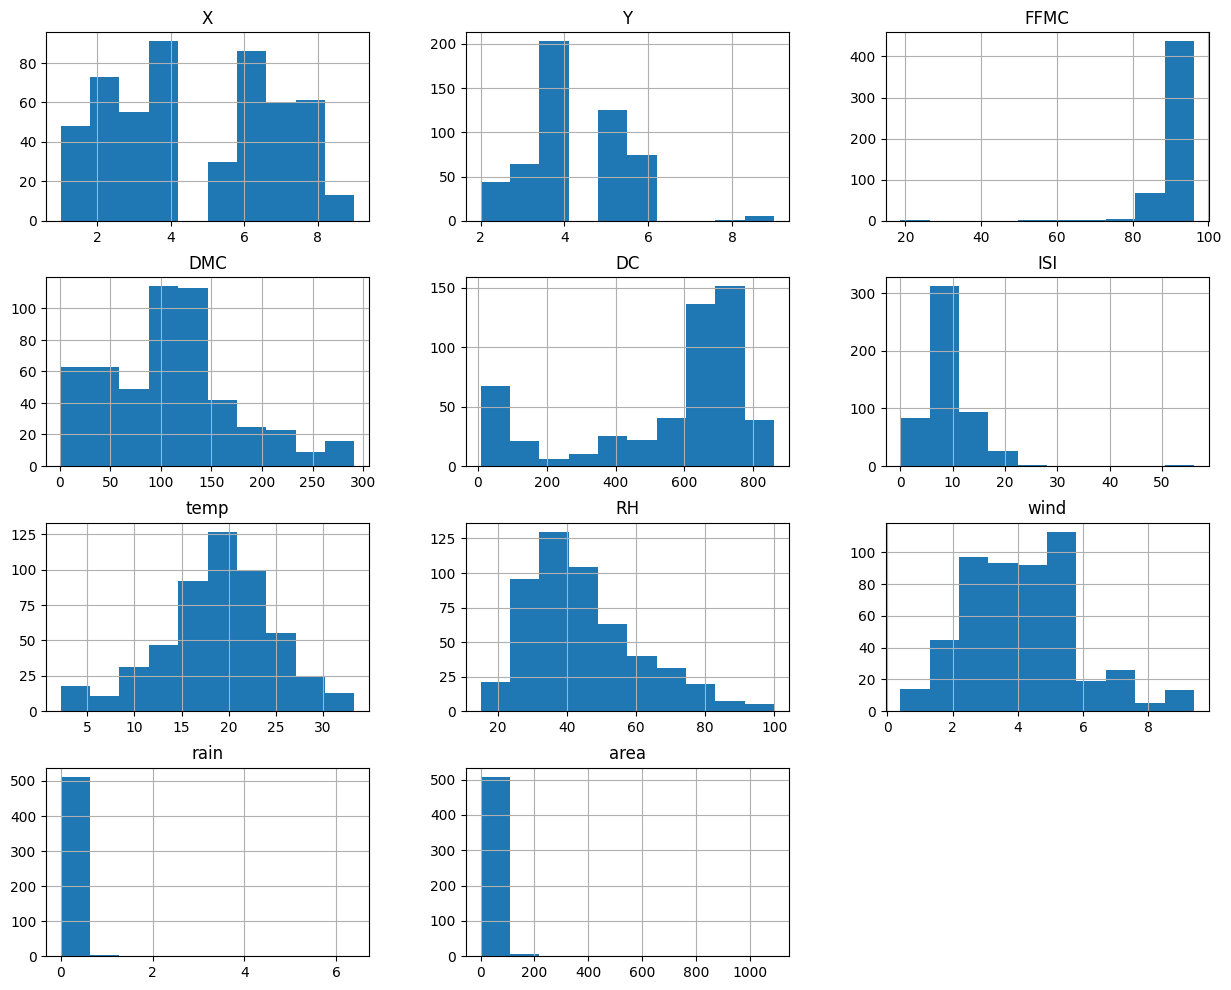

In [95]:
# Example: Histograms for numerical features
df.hist(figsize=(15, 12))
plt.show()

In [96]:
# 2. Preprocessing and Data Split
categorical_features = ['month', 'day'] # Update with your features # Assuming 'month' and 'day' are categorical
numerical_features = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']  # Update with your features # Assuming these are your numerical features


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)])

# Assuming 'area' is your target variable based on earlier visualizations
X = df.drop('area', axis=1)  # Replace 'target_variable' with 'area'
y = df['area']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
# 3. Logistic Regression from Scratch (Simplified Example)
class MyLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            linear_pred = np.dot(X, self.weights) + self.bias
            predictions = self._sigmoid(linear_pred)

            dw = (1 / n_samples) * np.dot(X.T, (predictions - y))
            db = (1 / n_samples) * np.sum(predictions - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_pred = np.dot(X, self.weights) + self.bias
        y_approximated = self._sigmoid(linear_pred)
        y_approximated_cls = [1 if i > 0.5 else 0 for i in y_approximated] #Threshold at 0.5
        return np.array(y_approximated_cls)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))


In [98]:
# 4. Model Building and Evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return accuracy, report, cm


In [104]:
# 4. Model Building and Evaluation
from sklearn.metrics import mean_squared_error, r2_score # Import regression metrics

def evaluate_regression_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

# ... (rest of your code) ...

# Model 1: Applying regression metrics to your existing Logistic Regression model
# (This is not ideal as logistic regression is for classification)
# Note: This will likely still have low performance as Logistic Regression is not for regression
mse_my_logreg, r2_my_logreg = evaluate_regression_model(my_logreg, X_test_transformed, y_test)

print("\nMy Logistic Regression (used with regression metrics):")
print(f"Mean Squared Error: {mse_my_logreg:.4f}")
print(f"R-squared: {r2_my_logreg:.4f}")

# Alternatively, you should switch to using a regression model:
# For example, using Support Vector Regression (SVR)
from sklearn.svm import SVR # Import SVR

svr_model = SVR()
svr_model.fit(X_train_transformed, y_train)
mse_svr, r2_svr = evaluate_regression_model(svr_model, X_test_transformed, y_test)

print("\nSupport Vector Regression:")
print(f"Mean Squared Error: {mse_svr:.4f}")
print(f"R-squared: {r2_svr:.4f}")


My Logistic Regression (used with regression metrics):
Mean Squared Error: 12138.0456
R-squared: -0.0297

Support Vector Regression:
Mean Squared Error: 12128.2245
R-squared: -0.0289


In [100]:
# Model 2: Support Vector Regression (Scikit-learn)
pipeline_svr = Pipeline([('preprocessor', preprocessor), ('estimator', SVR())])  # Use SVR for regression
pipeline_svr.fit(X_train, y_train)

# Evaluate using a regression metric (e.g., mean squared error)
from sklearn.metrics import mean_squared_error

y_pred_svr = pipeline_svr.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)

print("\nSupport Vector Regressor:")
print(f"Mean Squared Error: {mse_svr:.4f}")


Support Vector Regressor:
Mean Squared Error: 12128.2245


In [ ]:
# Model 3: Support Vector Classifier (SVC) - Modified for Regression
from sklearn.svm import SVR # Import SVR for regression

pipeline_svr = Pipeline([('preprocessor', preprocessor), ('regressor', SVR())]) # Use SVR instead of SVC
pipeline_svr.fit(X_train, y_train)

# Evaluate using a regression metric (e.g., mean squared error)
from sklearn.metrics import mean_squared_error

y_pred_svr = pipeline_svr.predict(X_test)
mse_svr = mean_squared_error(y_test, y_pred_svr)

print("\nSupport Vector Regressor:")
print(f"Mean Squared Error: {mse_svr:.4f}")

In [105]:
# 5. Hyperparameter Tuning (SVR Example)
from sklearn.svm import SVR # Import SVR for regression
from sklearn.metrics import mean_squared_error # Import appropriate metric

# Define the pipeline (this might be already defined elsewhere in your code)
pipeline_svr = Pipeline([('preprocessor', preprocessor), ('regressor', SVR())])

# Define the parameter grid for SVR
param_grid_svr = {
    'regressor__C': [0.1, 1, 10],
    'regressor__kernel': ['rbf', 'linear']
}

# Use 'neg_mean_squared_error' for regression tasks
grid_search_svr = GridSearchCV(pipeline_svr, param_grid_svr, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_svr.fit(X_train, y_train)
best_svr_model = grid_search_svr.best_estimator_
print("\nBest SVR Hyperparameters:", grid_search_svr.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best SVR Hyperparameters: {'regressor__C': 10, 'regressor__kernel': 'rbf'}


In [107]:
# 6. Feature Selection (SVC Example - SelectKBest with chi2)
# Use 'f_classif' instead of 'chi2' for data with negative values
from sklearn.feature_selection import f_classif

selector_svc = SelectKBest(f_classif, k=5)
X_train_transformed = preprocessor.fit_transform(X_train) # Fit and transform training data
X_test_transformed = preprocessor.transform(X_test)    # Transform test data
X_train_selected_svc = selector_svc.fit_transform(X_train_transformed, y_train)
X_test_selected_svc = selector_svc.transform(X_test_transformed)

# Get feature names from the transformed data
# Get the names of all features after transformation
all_transformed_feature_names = preprocessor.get_feature_names_out()

# Get the indices of the selected features
selected_feature_indices = selector_svc.get_support(indices=True)

# Get the names of the selected features
selected_features_svc = [all_transformed_feature_names[i] for i in selected_feature_indices]

print("\nSelected Features for SVC:", selected_features_svc)


Selected Features for SVC: ['cat__month_dec', 'cat__month_jul', 'cat__month_may', 'num__temp', 'num__rain']


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


In [106]:
# 7. Final Model (SVC) - Modified for Regression
# Use the best SVR model for prediction

final_svr_pipeline = best_svr_model  # Assign the best SVR model

final_svr_pipeline.fit(X_train, y_train)

# Evaluate using a regression metric (e.g., mean squared error)
from sklearn.metrics import mean_squared_error

y_pred_svr_final = final_svr_pipeline.predict(X_test)
mse_svr_final = mean_squared_error(y_test, y_pred_svr_final)

print("\nFinal SVR Model:")
print(f"Mean Squared Error: {mse_svr_final:.4f}")


Final SVR Model:
Mean Squared Error: 12115.6570
